# Generate auto- or cross-correlation function between 2 given catalogs

In [1]:
import os
import tempfile
import time
import copy

import numpy as np
import scipy
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 12})

from pypower import CatalogMesh, MeshFFTPower, CatalogFFTPower, PowerSpectrumStatistics, utils, setup_logging
from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, BoxSubsampler, project_to_wp, utils, setup_logging
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
from cosmoprimo import *

import catalog_data
import density_split

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
catalog_name = 'AbacusSummit_1Gpc_z1.175'
#catalog_name = 'AbacusSummit_2Gpc_z1.175'
#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = density_split.DensitySplit.load(output_dir+catalog_name+'_density_split.npy')

## Correlation galaxies-galaxies

### Generate catalogs of random points in each split

In [4]:
split_positions = catalog.sample_splits(size=catalog.data.size, seed=41, update=False)

### Generate random catalogs

In [5]:
# Generate random catalogs to compare catalog with when computing correlation function
def generate_catalogs(size, boxsize, offset, seed=42):
    rng = np.random.RandomState(seed=seed)
    positions = [o + rng.uniform(0., 1., size)*b for o, b in zip(offset, boxsize)]
    return positions

split_randoms_positions = generate_catalogs(size=6*catalog.data.size, boxsize=(catalog.boxsize,)*3, offset=(catalog.offset,)*3, seed=42)
catalog_randoms_positions = generate_catalogs(size=6*catalog.data.size, boxsize=(catalog.boxsize,)*3, offset=(catalog.offset,)*3, seed=43)

In [6]:
split_samples = catalog.sample_splits(size=6*catalog.data.size, seed=44, update=True)

### Correlation function in each density split

In [7]:
edges = (np.linspace(0., 150., 51), np.linspace(-1, 1, 201))

In [8]:
results_analytic = list()

for i in range(catalog.nsplits):
    # Galaxies in density split vs. all galaxies
    result_gg = TwoPointCorrelationFunction('smu', edges,
                                         data_positions1=catalog.split_positions[i], data_positions2=catalog.data.positions,
                                         boxsize=catalog.boxsize,
                                         engine='corrfunc', nthreads=128,
                                         los = 'x')
    
    # Random points in density split vs. all galaxies
    result_dg = TwoPointCorrelationFunction('smu', edges,
                                         data_positions1=split_positions[i], data_positions2=catalog.data.positions,
                                         boxsize=catalog.boxsize,
                                         engine='corrfunc', nthreads=128,
                                         los = 'x')
    
    results_analytic.append({'gg': result_gg, 'dg': result_dg}) 

In [ ]:
results_wRandoms = list()

for i in range(catalog.nsplits):
    # Galaxies in density split vs. all galaxies
    result_gg_wRandoms = TwoPointCorrelationFunction('smu', edges,
                                                  data_positions1=catalog.split_positions[i], data_positions2=catalog.data.positions,
                                                  randoms_positions1=split_randoms_positions, randoms_positions2=catalog_randoms_positions,
                                                  engine='corrfunc', nthreads=128,
                                                  los = 'x')
    
    # Random points in density split vs. all galaxies
    result_dg_wRandoms = TwoPointCorrelationFunction('smu', edges,
                                                  data_positions1=split_positions[i], data_positions2=catalog.data.positions,
                                                  randoms_positions1=split_randoms_positions, randoms_positions2=catalog_randoms_positions,
                                                  engine='corrfunc', nthreads=128,
                                                  los = 'x')
    
    results_wRandoms.append({'gg_wRandoms': result_gg_wRandoms, 'dg_wRandoms': result_dg_wRandoms}) 

In [ ]:
results_wSplitRandoms = list()

for i in range(catalog.nsplits):
    # Galaxies in density split vs. all galaxies
    result_gg_wSplitRandoms = TwoPointCorrelationFunction('smu', edges,
                                                      data_positions1=catalog.split_positions[i], data_positions2=catalog.positions,
                                                      randoms_positions1=catalog.split_samples[i], randoms_positions2=catalog_randoms_positions,
                                                      engine='corrfunc', nthreads=128,
                                                      los = 'x')
    
    # Random points in density split vs. all galaxies
    result_dg_wSplitRandoms = TwoPointCorrelationFunction('smu', edges,
                                                      data_positions1=split_positions[i], data_positions2=catalog.positions,
                                                      randoms_positions1=catalog.split_samples[i], randoms_positions2=catalog_randoms_positions,
                                                      engine='corrfunc', nthreads=128,
                                                      los = 'x')
    
    results_wSplitRandoms.append({'gg_wSplitRandoms': result_gg_wSplitRandoms, 'dg_wSplitRandoms': result_dg_wSplitRandoms}) 

In [ ]:
np.save(output_dir+catalog_name+'_corrFunc_randoms_tests', results_dict_list)

In [19]:
results = np.load(output_dir+catalog_name+'_corrFunc_randoms_tests.npy', allow_pickle=True)

## Plot results

In [20]:
# Let us project to multipoles (monopole, quadruple, hexadecapole)
ells = (0, 2, 4)
nells = len(ells)

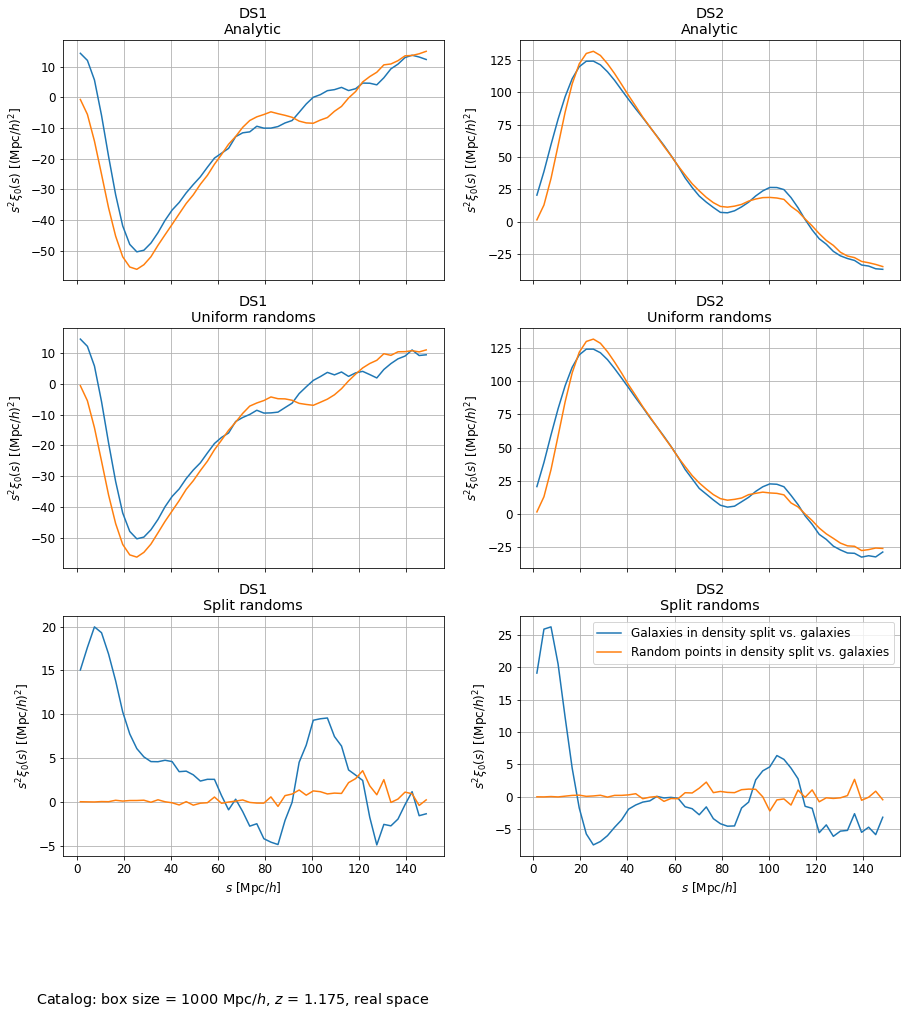

In [21]:
plt.rcParams["figure.figsize"] = (15, 15)
fig, axes = plt.subplots(3, 2, sharex=True, sharey=False)

for i in range(catalog.nsplits):
    results_dict = results[i]
    
    s, xiell_gg = results_dict['gg'].get_corr(ells=ells, return_sep=True)
    xiell_gg_wRandoms = results_dict['gg_wRandoms'].get_corr(ells=ells, return_sep=False)
    xiell_gg_wSplitRandoms = results_dict['gg_wSplitRandoms'].get_corr(ells=ells, return_sep=False)

    xiell_dg = results_dict['dg'].get_corr(ells=ells, return_sep=False)
    xiell_dg_wRandoms = results_dict['dg_wRandoms'].get_corr(ells=ells, return_sep=False)
    xiell_dg_wSplitRandoms = results_dict['dg_wSplitRandoms'].get_corr(ells=ells, return_sep=False)

    axes[0][i].plot(s, s**2 * xiell_gg[0], label='Galaxies in density split vs. galaxies')
    axes[0][i].plot(s, s**2 * xiell_dg[0], label='Random points in density split vs. galaxies')
    axes[0][i].set_ylabel(r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
    axes[0][i].grid(True)
    axes[0][i].set_title('DS{}'.format(i+1) +'\n'+ 'Analytic')
    
    axes[1][i].plot(s, s**2 * xiell_gg_wRandoms[0], label='Galaxies in density split vs. galaxies')
    axes[1][i].plot(s, s**2 * xiell_dg_wRandoms[0], label='Random points in density split vs. galaxies')
    axes[1][i].set_ylabel(r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
    axes[1][i].grid(True)
    axes[1][i].set_title('DS{}'.format(i+1) +'\n'+ 'Uniform randoms')
    
    axes[2][i].plot(s, s**2 * xiell_gg_wSplitRandoms[0], label='Galaxies in density split vs. galaxies')
    axes[2][i].plot(s, s**2 * xiell_dg_wSplitRandoms[0], label='Random points in density split vs. galaxies')
    axes[2][i].set_ylabel(r'$s^2 \xi_0(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
    axes[2][i].grid(True)
    axes[2][i].set_title('DS{}'.format(i+1) +'\n'+ 'Split randoms')
    
    axes[2][i].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

plt.suptitle('Catalog: box size = {:.0f} Mpc/$h$, $z$ = {:.3f}, real space'.format(catalog.boxsize, catalog.data.redshift),
             ha='left', x=0.1, y=0)

plt.legend()
plt.show()